In [354]:
from scipy.ndimage.filters import convolve

In [459]:
%run netCDF_Processing.py

In [232]:
cdf = CDFData(hgt_path = "E:\hgt.2012.nc",
              uwind_path = r"E:\uwnd.2012.nc",
              vwind_path = r"E:\vwnd.2012.nc")

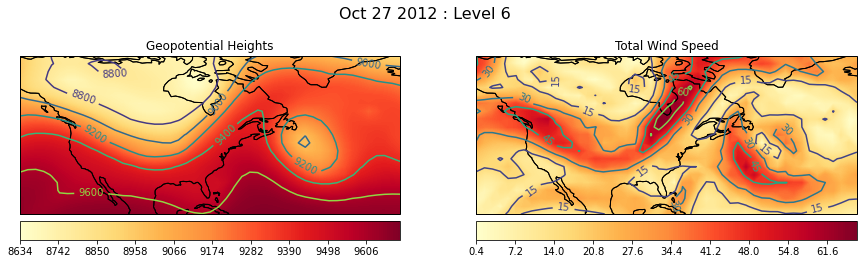

In [233]:
cdf.plot('all',(10,27),6,figsize=(15,4))
plt.show()

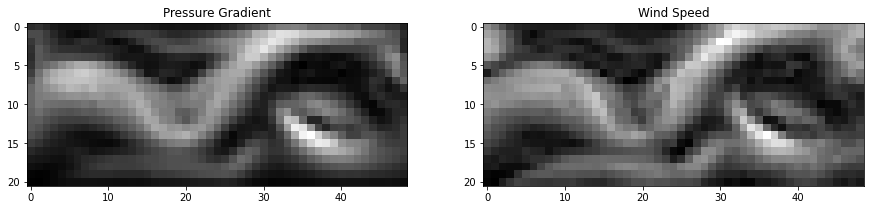

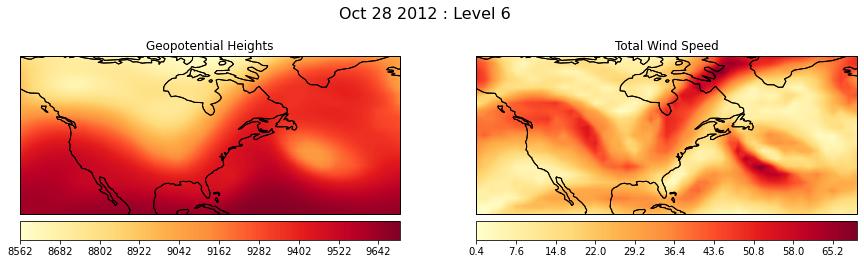

In [680]:
day = cdf.date_to_day((10,28))
level = 6
winds = cdf.loc_winds[day-1,level-1,...]
hgts = cdf.loc_hgts[day-1,level-1,...]

x_grad_kernel = np.array([[-1,0,1]])
y_grad_kernel = x_grad_kernel.reshape(-1,1)

x_grad = convolve(hgts,x_grad_kernel)
y_grad = convolve(hgts,y_grad_kernel)

grad = np.sqrt(np.square(x_grad) + np.square(y_grad))

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(grad,cmap='gist_gray')
ax[0].set_title('Pressure Gradient')
ax[1].imshow(winds,cmap='gist_gray')
ax[1].set_title('Wind Speed')
cdf.plot('all',day,level, contours=0)
plt.show()

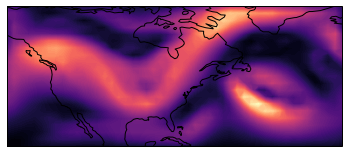

In [681]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.contourf(cdf.loc_lons, cdf.loc_lats,grad,cmap='magma', levels=100)

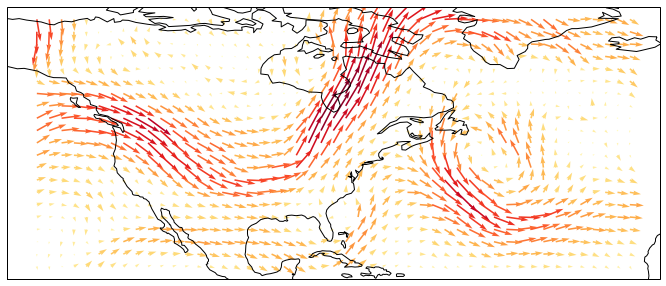

In [682]:
fig, ax = cdf.quiver((10,27),6)

# Masking

In [586]:
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import gaussian

Match Score: 47.61%


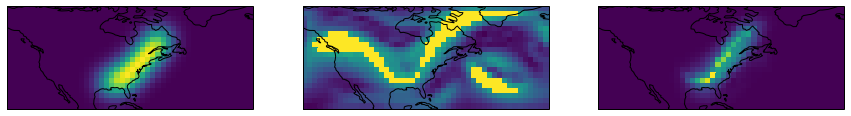

In [749]:
mask_img = imread(r"C:/Users/Administrator/Downloads/little_further_inward.png", as_gray=True)
mask_img = resize(mask_img,hgts.shape)
mask_img = normalize(gaussian(mask_img,sigma=2))
# mask_img[mask_img < mask_img.max()/10] = 0

fig, (ax1,ax2,ax3) = plt.subplots(1,3, subplot_kw={'projection':ccrs.PlateCarree()},figsize=(15,5))
ax1.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img)
ax1.coastlines()

thresh = 0.6
thresh_grad = normalize(grad.copy())
thresh_grad[thresh_grad > thresh] = 1
masked_grad = mask_img*thresh_grad

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,thresh_grad)
ax2.coastlines()

ax3.pcolor(cdf.loc_lons, cdf.loc_lats,masked_grad)
ax3.coastlines()

score = masked_grad.sum()/mask_img.sum()
print(f'Match Score: {round(score*100,2)}%')

In [723]:
def get_score(hgts,thresh=0):
    grad = gradient(hgts)
    masked_grad = mask_img*normalize(grad)
    
    if thresh:
        thresh_grad = normalize(grad.copy())
        thresh_grad[thresh_grad > thresh] = 1
        masked_grad = mask_img*thresh_grad
    
    score1 = masked_grad.sum()/mask_img.sum()

    return score1

In [750]:
level = 5
thresh = 0.6

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    hgts = cdf.loc_hgts[day-1,level-1,...]
    scores[day] = get_score(hgts,thresh=thresh)

arg_scores = np.argsort(scores)

Score: 67.85%


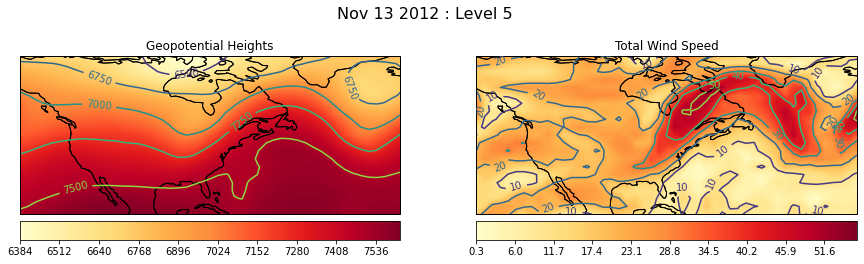

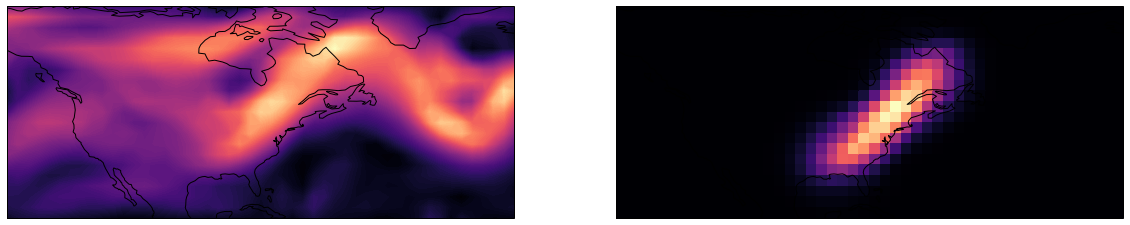

In [753]:
n = 2
cdf.plot('all',int(arg_scores[-n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {round(scores[arg_scores[-n]]*100,2)}%')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

# Top 10 Results

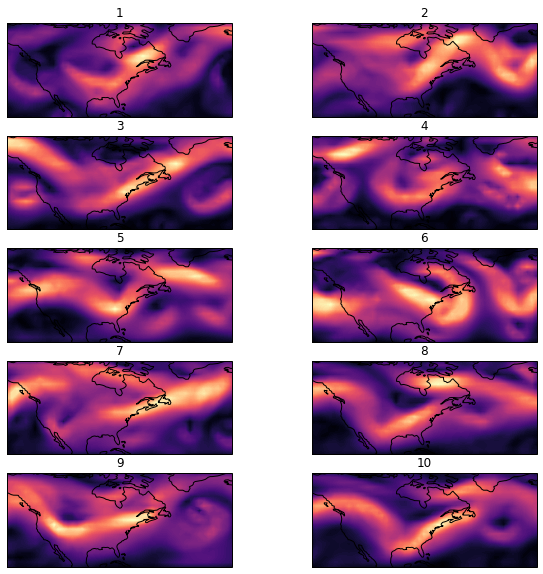

In [754]:
fig, axes = plt.subplots(5,2, figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
for n in range(1,11):
    
    cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    ax = axes.ravel()[n-1]
    ax.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)
    ax.coastlines()
    ax.set_title(n)

# Using Wind Data

(<Figure size 864x360 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x215ee90fa08>)

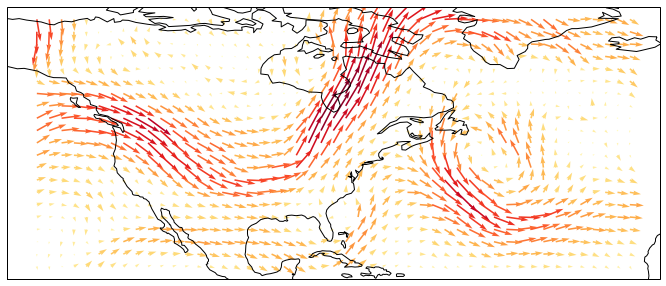

In [779]:
level = 6
ref_day = cdf.date_to_day((10,27))

# cdf.localize(lat0=30,lat1=70,lon0=-90,lon1=-65)

cdf.localize()
u_winds = cdf.loc_u_winds[ref_day-1,level-1,...]
u_winds = (u_winds/cdf.loc_winds[ref_day-1,level-1,...])*mask_img
v_winds = cdf.loc_v_winds[ref_day-1,level-1,...]
v_winds = (v_winds/cdf.loc_winds[ref_day-1,level-1,...])*mask_img
cdf.quiver((10,27), 6)

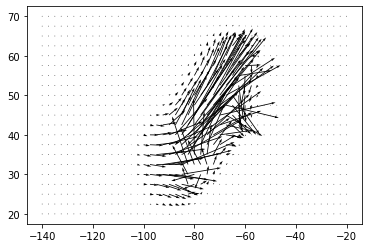

In [780]:
plt.quiver(cdf.loc_lons,cdf.loc_lats,u_winds,v_winds)

In [857]:
def match_score(u_wnd,v_wnd):
    wnd = np.sqrt(np.square(u_wnd) + np.square(u_wnd))
    
    u_comp = normalize(u_wnd)*u_winds
    v_comp = normalize(v_wnd)*v_winds
    
    return np.sqrt(np.square(u_comp) + np.square(u_comp)).sum()

In [858]:
level = 6

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    u_wnds = cdf.loc_u_winds[day-1,level-1,...]
    v_wnds = cdf.loc_v_winds[day-1,level-1,...]
    
    scores[day] = match_score(u_wnds,v_wnds)

arg_scores = np.argsort(scores)

Score: 0.053642794534028405


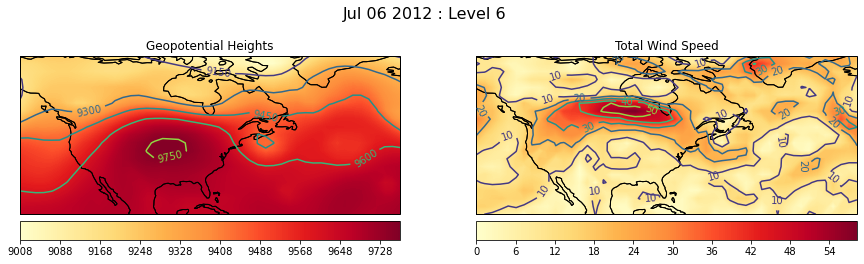

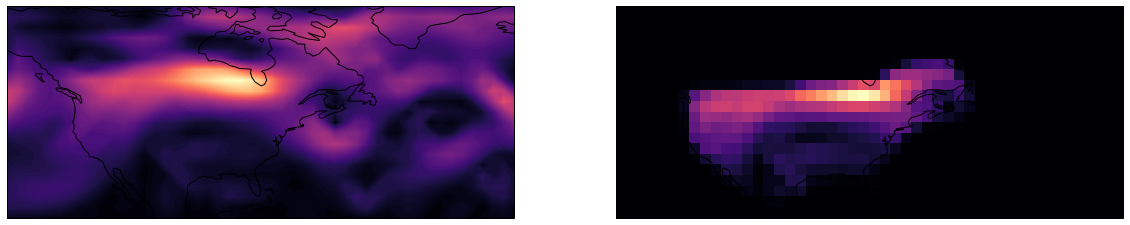

In [859]:
n = 1

cdf.plot('all',int(arg_scores[-n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[-n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

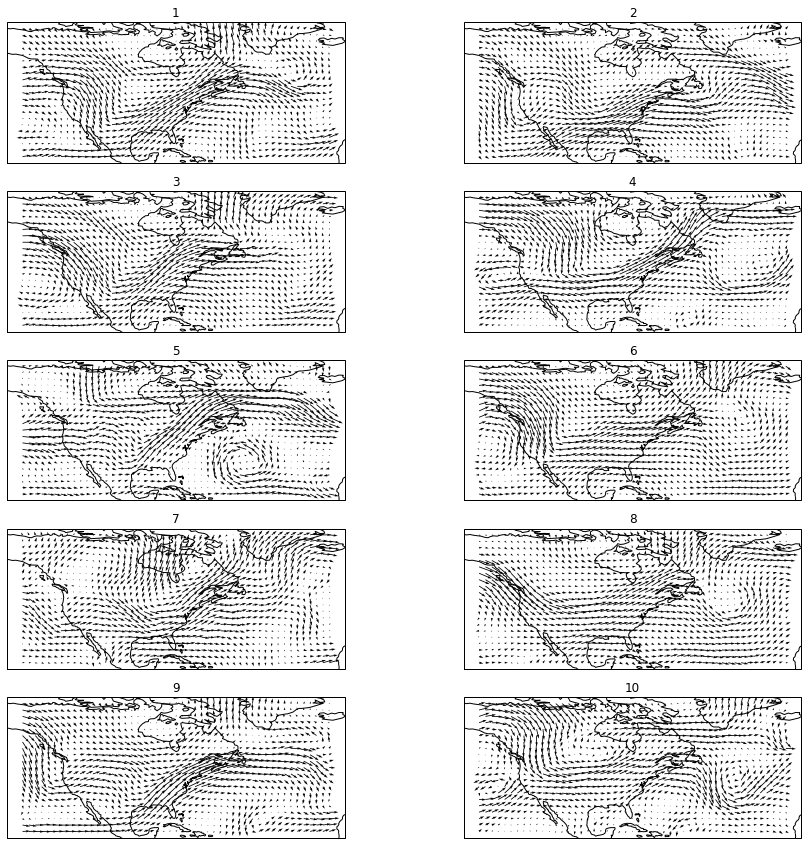

In [831]:
fig, axes = plt.subplots(5,2, figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})
for n in range(1,11):
    
    cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    cur_uwinds = cdf.loc_u_winds[arg_scores[-n]-1,level-1,...]
    cur_vwinds = cdf.loc_v_winds[arg_scores[-n]-1,level-1,...]
    
    ax = axes.ravel()[n-1]
#     ax.contourf(cdf.loc_lons, cdf.loc_lats, cur_grad, cmap='magma', levels=100)
    ax.quiver(cdf.loc_lons,cdf.loc_lats,cur_uwinds,cur_vwinds)
    ax.coastlines()
    ax.set_title(n)

### Try Vector Mask

In [839]:
mask_img = imread(r"C:/Users/Administrator/Downloads/continental_US_mask.png", as_gray=True)
mask_img = resize(mask_img,hgts.shape)
# mask_img = normalize(gaussian(mask_img,sigma=1))

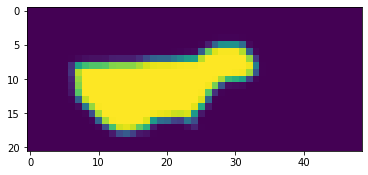

In [840]:
plt.imshow(mask_img)

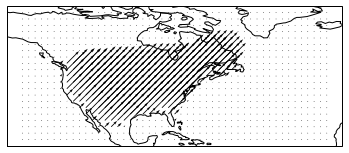

In [843]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
# u = mask_img*np.cos(np.deg2rad(45))
# v = mask_img*np.cos(np.deg2rad(45))
# u = np.roll(u,-3)
# v = np.roll(v,-3)
ax.quiver(cdf.loc_lons, cdf.loc_lats, u,v)
ax.coastlines()

In [864]:
'''
def match_score(u_wnd,v_wnd):
    u_comp = normalize(u_wnd)*u
    v_comp = normalize(v_wnd)*v
    return u_comp.sum() + v_comp.sum()
'''
def match_score(uwnd,vwnd):
    day = cdf.date_to_day((10,28))
    level = 6
    uwnd = normalize(uwnd*mask_img)
    vwnd = normalize(vwnd*mask_img)
    
    loc_u_wind = normalize(cdf.loc_u_winds[day-1,level-1,...])*mask_img
    loc_v_wind = normalize(cdf.loc_v_winds[day-1,level-1,...])*mask_img
    u_comp = loc_u_wind - uwnd
    v_comp = loc_v_wind - vwnd
    
    return (np.sqrt(np.square(u_comp) + np.square(v_comp)).sum())

level = 6

scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    u_wnds = cdf.loc_u_winds[day-1,level-1,...]
    v_wnds = cdf.loc_v_winds[day-1,level-1,...]
    
    scores[day] = match_score(u_wnds,v_wnds)

arg_scores = np.argsort(scores)

Score: 715.1471778203563


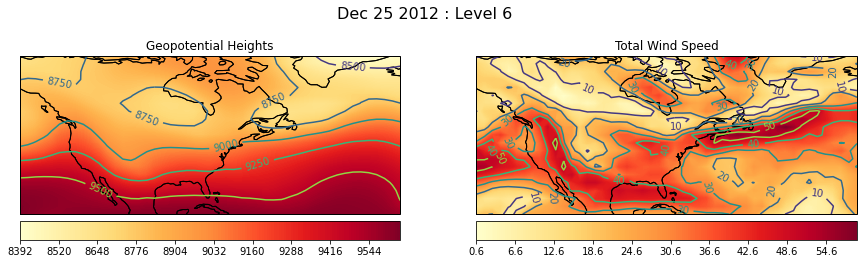

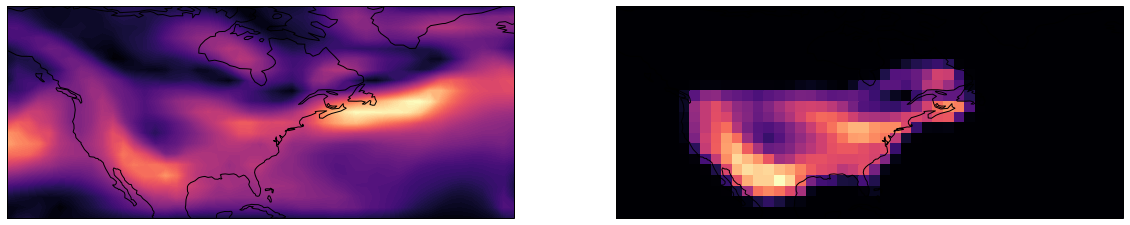

In [865]:
n = 1
cdf.plot('all',int(arg_scores[-n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[-n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

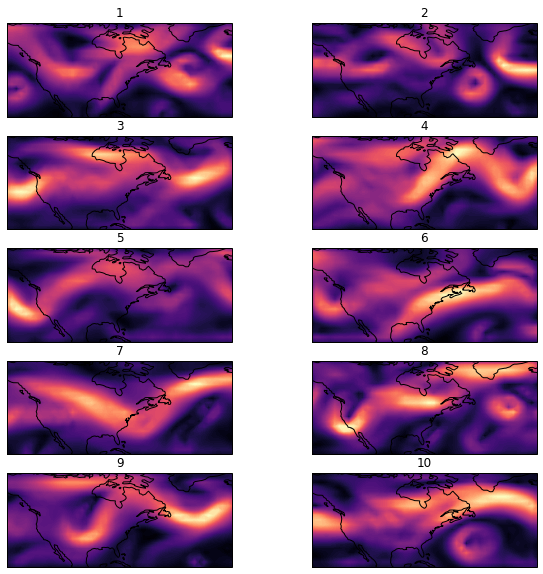

In [853]:
fig, axes = plt.subplots(5,2, figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})

for n in range(1,11):
    
    cur_hgts = cdf.loc_hgts[arg_scores[-n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    ax = axes.ravel()[n-1]
    ax.contourf(cdf.loc_lons, cdf.loc_lats, cur_grad, cmap='magma', levels=100)
    ax.coastlines()
    ax.set_title(n)

# Match Similarity to Oct 28

In [895]:
level = 6
day = cdf.date_to_day((10,28))

mask_img = imread(r"C:/Users/Administrator/Downloads/continental_US_mask.png", as_gray=True)
mask_img = resize(mask_img,cdf.loc_hgts[day-1,level-1].shape)

loc_u_winds = normalize(cdf.loc_u_winds[day-1,level-1,...]*mask_img)
loc_v_winds = normalize(cdf.loc_v_winds[day-1,level-1,...]*mask_img)

def match_score(uwnd,vwnd):
    # Higher score is worse
    uwnd = normalize(uwnd*mask_img)
    vwnd = normalize(vwnd*mask_img)
    diff = np.sqrt(np.square(uwnd-loc_u_winds)+np.square(vwnd-loc_v_winds))
    masked_diff = diff*mask_img
    
    return masked_diff.sum()

In [896]:
cur_day = cdf.date_to_day((10,28))
cur_uwnd = cdf.loc_u_winds[cur_day-1,level-1,...]
cur_vwnd = cdf.loc_v_winds[cur_day-1,level-1,...]

print(match_score(cur_uwnd,cur_vwnd)) # Match between oct 28 and oct 28 is 0 -> perfect match obviously

0.0


In [897]:
scores = np.zeros(cdf.hgts.shape[0])
days = np.arange(cdf.hgts.shape[0])

for day in days:
    u_wnds = cdf.loc_u_winds[day-1,level-1,...]
    v_wnds = cdf.loc_v_winds[day-1,level-1,...]
    
    scores[day] = match_score(u_wnds,v_wnds)

arg_scores = np.argsort(scores)

Score: 48.653577395099035


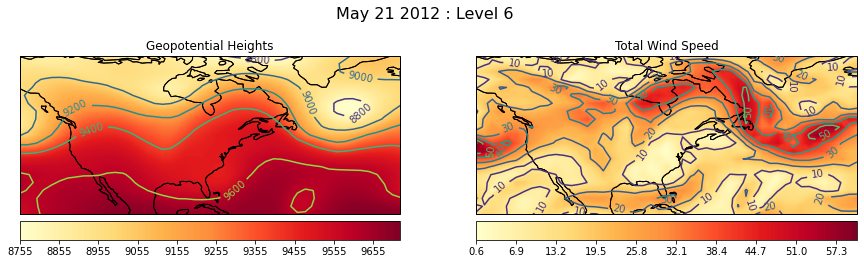

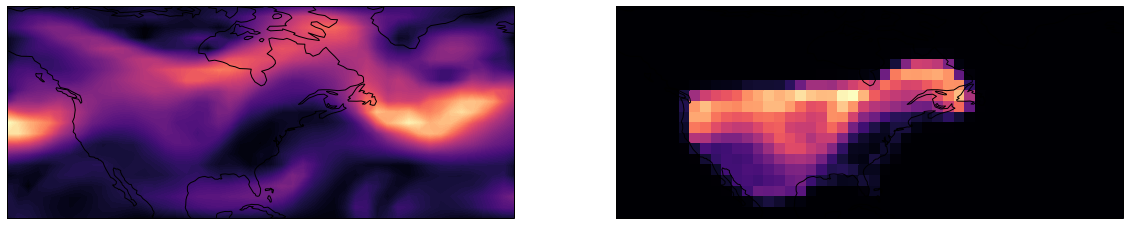

In [905]:
n = 6
cdf.plot('all',int(arg_scores[n]),level)

cur_hgts = cdf.loc_hgts[arg_scores[n]-1,level-1,...]
cur_grad = gradient(cur_hgts)
print(f'Score: {scores[arg_scores[n]]}')
fig, (ax1,ax2) = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,5))
ax1.coastlines()
ax1.contourf(cdf.loc_lons, cdf.loc_lats,cur_grad,cmap='magma', levels=100)

ax2.pcolor(cdf.loc_lons, cdf.loc_lats,mask_img*normalize(cur_grad),cmap='magma')
ax2.coastlines()
plt.show()

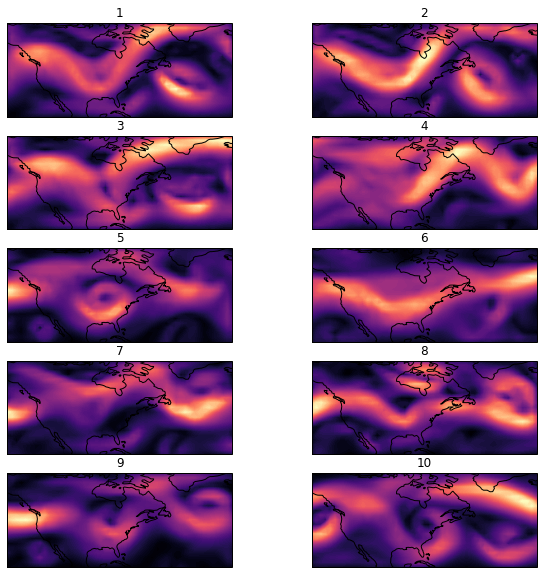

In [907]:
fig, axes = plt.subplots(5,2, figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})

for n in range(10):
    
    cur_hgts = cdf.loc_hgts[arg_scores[n]-1,level-1,...]
    cur_grad = gradient(cur_hgts)
    
    ax = axes.ravel()[n]
    ax.contourf(cdf.loc_lons, cdf.loc_lats, cur_grad, cmap='magma', levels=100)
    ax.coastlines()
    ax.set_title(n+1)